<a href="https://colab.research.google.com/github/AbelGPenas/memeAI/blob/main/memeAI_Proof-of-concept.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1- Environment set-up

Mount the drive image to store the dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Switch to the project dataset

In [2]:
%cd /content/drive/MyDrive/Projects/MemeAI/

/content/drive/MyDrive/Projects/MemeAI


In [3]:
%matplotlib inline

## 1.1- Import dataset from Drive to the notebook environment

Create a folder with the two class folders inside (easing the use of the ImageFolder class in Pytorch). The images are imported from drive.

In [4]:
!mkdir /content/meme_images/

In [5]:
!cp -r ./meme/ /content/meme_images/meme/
!cp -r ./valuable/ /content/meme_images/valuable/

# 2- Description of the dataset and problem

The goal of this CNN is to save me some work filtering out the images I dont want to keep in my whats app media folder. This undesired images comprise:
* Screenshots from news, chats and social media. *Yep, we all send and receive this kind of stuff and remains there forever*.
* Memes. *Sometimes they are brilliant, but I already have google if I need them*.
* Those images with corny texts that your mum sends you to inspire you. *Cute but not enough to keep them forever*.

What I want to keep:
* Proper pictures. *Yep, maybe those are pictures from god knows who in a wpp group lost in the shadow of time, but lets make things a bit simpler for this poor AI*.

Some few images can be seen in [section 5.2](https://colab.research.google.com/drive/1cmgaPrUzelnkEt6DYJ5Xl6dWgJ8W94AK#scrollTo=g8VTxcobkiND)

# 3- Designing the CNN (Pytorch)

## 3.1- Deep learning environment set-up

Set up the environment with the relevant libraries

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import os

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.9.0+cu102  Device: cuda


## 3.2- Data loading

The Images are loader with the ImageFolder class, with automatically labels them as a function of the name of the folder in which they are contained.

Some transformations are applied:
* Fix the image size into a 256x256 square
* Convert into a tensor.
* Normalize the tensor values with mean and std deviation of 0.5

In [7]:
root_dir = '/content/meme_images/'
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.ImageFolder(root=root_dir, transform=transform)

We define the batch size of the training loader as 32. We **stratify** the split between train and validation, so every set has the same proportions of observations from each class.

The whole dataset is subsetted regarding these stratified indeces, and 2 dataloader classes are instantiated from these subsets.

In [8]:
batch_size=128

train_index, val_index = train_test_split(
    np.arange(len(dataset.targets)),
    test_size=0.2,
    shuffle=True,
    stratify=dataset.targets
)
val_set = Subset(dataset, val_index)
train_set = Subset(dataset, train_index)

train_loader = DataLoader(dataset=train_set, 
                          batch_size=batch_size, 
                          shuffle=True,
                          num_workers=2)

validation_loader = DataLoader(dataset=val_set, 
                               batch_size=len(val_index), 
                               shuffle=False,
                               num_workers=2)

## 3.3- Model building

A convolution neural network is built with 3 layers of convolutions and 3 ReLu activated linear layers until deriving into 3 output nodes.

Max pooling is including in the architechture after each convolutional layer.

Regularization by dropout is included for the linear layers.

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 9, 5) #From 3 to 9 channels, 5x5 kernel -> 9,252,252
        self.pool = nn.MaxPool2d(2, 2) # 2x2 maxPooling -> 9,126,126
        self.conv2 = nn.Conv2d(9, 18, 5) # 9 to 18 channels, 5x5 kernel -> 18,122,122
        # -> 18,61,61
        self.conv3 = nn.Conv2d(18, 36, 6) # 18 to 36 channels, 6x6 kernel -> 36,56,56
        # -> 36,28,28
        self.fc1 = nn.Linear(36 * 28 * 28, 120)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(120, 84)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 36*28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        x = self.fc3(x)
        return x

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (conv1): Conv2d(3, 9, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(9, 18, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(18, 36, kernel_size=(6, 6), stride=(1, 1))
  (fc1): Linear(in_features=28224, out_features=120, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


In the summary below it is possible to see the structure of the CNN, as well as the dimensions of each layer.

In [10]:
from torchsummary import summary

input_shape = (3,256,256)
summary(Net().cuda(), input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 9, 252, 252]             684
         MaxPool2d-2          [-1, 9, 126, 126]               0
            Conv2d-3         [-1, 18, 122, 122]           4,068
         MaxPool2d-4           [-1, 18, 61, 61]               0
            Conv2d-5           [-1, 36, 56, 56]          23,364
         MaxPool2d-6           [-1, 36, 28, 28]               0
            Linear-7                  [-1, 120]       3,387,000
           Dropout-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
          Dropout-10                   [-1, 84]               0
           Linear-11                    [-1, 2]             170
Total params: 3,425,450
Trainable params: 3,425,450
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forw

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Two functions are defined to train and test the model. The train function will:
* Set the model in train() mode.
* Load the data into the GPU used.
* Set the gradients to zero before triggering the backpropagation.
* Pass the data through the network.
+ Calculate the model Crossentropy loss comparing with the labels.
* Trigger the backpropagation.
* Update the model parameters based ont he calculated gradient.
* Print a progress update.
* Return the average loss for the epoch (excluding the last batch, with few samples).


In [11]:
def train(model, optimizer, epoch):
    # Set model to training mode
    model.train()
    loss_vect = []
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):

        # Copy data to GPU
        data = data.to(device)
        target = target.to(device)
        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        loss_vect.append(loss.data.item())
        # Update weights
        optimizer.step()
        

        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.data.item()))

    return np.mean(loss_vect[:-1])

On its side, the validate function:
* Sets the model in evaluation mode.
* Uploads the images and labels to the GPU.
* Computes hte average loss and the accuracy of the model on the validation set.
* Print the results on the screen and return the loss, the accuracy and the output instance.

In [12]:
def validate(model, loss_vector, accuracy_vector):
    train_loss = model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))
    return val_loss, float(accuracy), output


# 4- Run the experiment

We define the number of epochs for the training and create a dict to gather the metrics during the training.

In [13]:
epochs = 24

lossv, accv = [], []
exp_dict = {
    'validation_accuracy': [],
    'train_loss': [],
    'validation_loss': []
}

The model is trained and evaluated epoch by epoch. 

At each iteration, we print the loss and the progress of the training and the loss and accuracy on the test dataset.

In [14]:
%%time

for epoch in range(1, epochs + 1):
    train_loss = train(model, optimizer, epoch)
    val_loss, val_acc, output = validate(model, lossv, accv)
    for key, value in zip(exp_dict.keys(), [val_acc, train_loss, val_loss]):
      exp_dict[key].append(value)

Train Epoch: 1 [0/2244 (0%)]	Loss: 0.691714
Train Epoch: 1 [128/2244 (6%)]	Loss: 0.689462
Train Epoch: 1 [256/2244 (11%)]	Loss: 0.685665
Train Epoch: 1 [384/2244 (17%)]	Loss: 0.682609
Train Epoch: 1 [512/2244 (22%)]	Loss: 0.678083
Train Epoch: 1 [640/2244 (28%)]	Loss: 0.665384
Train Epoch: 1 [768/2244 (33%)]	Loss: 0.683125
Train Epoch: 1 [896/2244 (39%)]	Loss: 0.669124
Train Epoch: 1 [1024/2244 (44%)]	Loss: 0.659710
Train Epoch: 1 [1152/2244 (50%)]	Loss: 0.618602
Train Epoch: 1 [1280/2244 (56%)]	Loss: 0.647183
Train Epoch: 1 [1408/2244 (61%)]	Loss: 0.617083
Train Epoch: 1 [1536/2244 (67%)]	Loss: 0.608171
Train Epoch: 1 [1664/2244 (72%)]	Loss: 0.692449
Train Epoch: 1 [1792/2244 (78%)]	Loss: 0.721657
Train Epoch: 1 [1920/2244 (83%)]	Loss: 0.605882
Train Epoch: 1 [2048/2244 (89%)]	Loss: 0.657503
Train Epoch: 1 [1156/2244 (94%)]	Loss: 0.571179

Validation set: Average loss: 0.6069, Accuracy: 322/561 (57%)

Train Epoch: 2 [0/2244 (0%)]	Loss: 0.627579
Train Epoch: 2 [128/2244 (6%)]	Loss: 0.6

# 5- Visualize the prediction results

## 5.1- Environment set-up

In [15]:
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

## 5.2- Visualize the results in the notebook

A subset of *n_imgs* from the validation set can be displayed together with the predicted and true labels as per the code below. Note that resizing and conversion into grayscale are not corrected in the code below, just the normalization transformation.

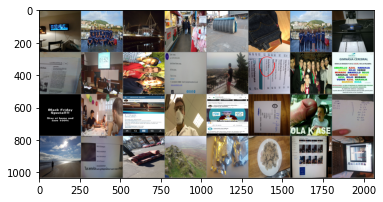

Predicted:  valuable valuable valuable valuable valuable valuable valuable valuable  meme  meme valuable  meme valuable valuable valuable  meme valuable  meme  meme valuable  meme  meme valuable  meme  meme  meme valuable valuable valuable valuable valuable valuable
True class: valuable valuable valuable valuable valuable valuable valuable valuable  meme valuable valuable  meme valuable  meme valuable  meme  meme valuable  meme valuable  meme  meme  meme  meme valuable  meme valuable valuable valuable valuable  meme  meme


In [17]:
n_img = 32 # images to show
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()     # convert to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get the predicted class index for each element in the val set
_, predicted = torch.max(output, 1)
# get some random training images
dataiter = iter(validation_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:n_img]))
# print labels
print('Predicted: ', ' '.join('%5s' % dataset.classes[int(predicted[j])] for j in range(n_img)))
print('True class:', ' '.join('%5s' % dataset.classes[int(labels[j])] for j in range(n_img)))

# 6- Performance metrics (after 24 epochs)

## 6.1- Accuracy by class

The accuracy for each class is shown below:



In [18]:
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))
classes = dataset.classes

with torch.no_grad():
    for data in validation_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(63):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of  meme : 76 %
Accuracy of valuable : 84 %


## 6.2- Confussion matrix

Instead of studying the recall or the f1-score, we can display a confusion matrix (in array form) as below to evaluate the relevance of false positives and false negatives for each clss.

In [19]:
stacked = torch.stack(
    (
        labels,
        predicted
    ),
    dim=1
)

In [20]:
cmt = torch.zeros(2,2, dtype=torch.int64)
for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1
print(cmt, classes)

tensor([[271,  49],
        [ 40, 201]]) ['meme', 'valuable']


As it can be seen, the main source of misclassification is non-valuable memes being classified as memes. This is expected since meme (non-valuable images) is quite a heterogeneous group.

# 7- Adding image metadata to the CNN

In order to take advantage from the fact that memes and invaluable images in my whats app are usually of more reduced size than the valuable images, we can add an extra node in the second linear layer (hence increasing from 120 to 121 nodes) to consider also the image side. This also requires some adjustments:

* The dataset __getitem__ method should also return the image size.
* The loader method needs to handle this triplet.
* The architecture of the net needs to be adjusted to concatenate the extra value in the second linear layer.
* The train and validate methods need to be modified to explicit this extra input in the for loop. 

## 7.1- Data loading with img size

We can create a custom dataset class inheriting from the ImageFolder. The __getitem__ method is overriden to extract the size of each image and add it to the original tuple. This size is normalized to avoid complications in the during the training, for which the min and max sizes for all the images are stored as attributes in the __init__ method (also overriden).

In [21]:
class memeFolder(datasets.ImageFolder):
  def __init__(self, root, transform):
    super(memeFolder, self).__init__(root, transform)
    # Get the max and min img size in the dataset as attributes
    self.max_size = max([os.path.getsize(path) for (path, label) in self.samples])
    self.min_size = min([os.path.getsize(path) for (path, label) in self.samples])

  def __getitem__(self, idx):
    # Override to return the pic size as well. This is what would be returned:
    original_tuple = super(memeFolder, self).__getitem__(idx)
    img_path = self.imgs[idx][0]
    img_size = os.path.getsize(img_path)
    # Apply min max normalization to the size variable
    norm_size = (img_size - self.min_size) / (self.max_size - self.min_size)
    # make a new tuple that includes original and the size
    tuple_with_size = (original_tuple + (norm_size,))
    return tuple_with_size

From here, the downstream process is analogous to the one above, with the only difference of the memeFolder class being used instead of the ImageFolder class

In [22]:
root_dir = '/content/meme_images/'
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset_wsize = memeFolder(root=root_dir, transform=transform)

We can easily print the stats for the size distribtion for the imgs in the two classes. As we can see, valuable images are larger in average, although the standard deviation is huge (suggesting a very skewed distribution).

This means that image size might not be such a good feature as thought.

In [24]:
sizes_meme = [os.path.getsize(path) for (path, label) in dataset_wsize.imgs if label == 0]
sizes_valuable = [os.path.getsize(path) for (path, label) in dataset_wsize.imgs if label == 1]
print(f'Meme images have a mean size of {np.mean(sizes_meme):.0f} and a standard deviation of {np.std(sizes_meme):.0f}')
print(f'Valuable images have a mean size of {np.mean(sizes_valuable):.0f} and a standard deviation of {np.std(sizes_valuable):.0f}')

Meme images have a mean size of 204397 and a standard deviation of 368445
Valuable images have a mean size of 280267 and a standard deviation of 325411


Also it is good to see how balanced the dataset is between our two classes.

In [25]:
print(f'Valuable images have a dataset size of {len(sizes_valuable):.0f}, while for the memes dataset is {len(sizes_meme):.0f}')

Valuable images have a dataset size of 1205, while for the memes dataset is 1600


The dataloader creation is analogous to the previous model.

In [26]:
batch_size=128

train_index, val_index = train_test_split(
    np.arange(len(dataset_wsize.targets)),
    test_size=0.2,
    shuffle=True,
    stratify=dataset_wsize.targets
)
val_set_wsize = Subset(dataset_wsize, val_index)
train_set_wsize = Subset(dataset_wsize, train_index)

train_loader_wsize = DataLoader(dataset=train_set_wsize, 
                          batch_size=batch_size, 
                          shuffle=True,
                          num_workers=2)

validation_loader_wsize = DataLoader(dataset=val_set_wsize, 
                               batch_size=len(val_index), 
                               shuffle=False,
                               num_workers=2)

## 7.2- Model building

In [27]:
class Net_wsize(nn.Module):
    def __init__(self):
        super(Net_wsize, self).__init__()
        self.conv1 = nn.Conv2d(3, 9, 5) #From 3 to 9 channels, 5x5 kernel -> 9,252,252
        self.pool = nn.MaxPool2d(2, 2) # 2x2 maxPooling -> 9,126,126
        self.conv2 = nn.Conv2d(9, 18, 5) # 9 to 18 channels, 5x5 kernel -> 18,122,122
        # -> 18,61,61
        self.conv3 = nn.Conv2d(18, 36, 6) # 18 to 36 channels, 6x6 kernel -> 36,56,56
        # -> 36,28,28
        self.fc1 = nn.Linear(36 * 28 * 28, 120)
        self.fc1_drop = nn.Dropout(0.2)
        # We modify the input size of this next layer to account for the extra value concatenated
        self.fc2 = nn.Linear(120, 84)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(85, 2)

    def forward(self, image, img_sizes):
      # We have now two inputs, so we store x2 for the image size for later use
        x2 = img_sizes.resize_((len(img_sizes), 1))
      # We run the convolution on the image as usual
        x1 = self.pool(F.relu(self.conv1(image)))
        x1 = self.pool(F.relu(self.conv2(x1)))
        x1 = self.pool(F.relu(self.conv3(x1)))
      # We run the first linear layer on the linearized conv values as usual
        x1 = x1.view(-1, 36*28*28)
        x1 = F.relu(self.fc1(x1))
        x1 = self.fc1_drop(x1)

      # We keep running the linear layers as usual
        x1 = F.relu(self.fc2(x1))
        x1 = self.fc2_drop(x1)
      # We concatenate the extra value to each sample
        x = torch.cat((x1, x2), dim=1)
        x = self.fc3(x)
        return x

model_wsize = Net_wsize().to(device)
optimizer = torch.optim.SGD(model_wsize.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

print(model_wsize)

Net_wsize(
  (conv1): Conv2d(3, 9, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(9, 18, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(18, 36, kernel_size=(6, 6), stride=(1, 1))
  (fc1): Linear(in_features=28224, out_features=120, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=85, out_features=2, bias=True)
)


The sizes are also loaded into the device, and passed as input to the forward run of the model.

In [28]:
def train_with_size(model, optimizer, epoch):
    # Set model to training mode
    model.train()
    loss_vect = []
    # Loop over each batch from the training set
    for batch_idx, (data, target, sizes) in enumerate(train_loader_wsize):
        # Copy data to GPU
        data = data.to(device)
        target = target.to(device)
        sizes = sizes.to(device)
        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data.float(), sizes.float())

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        loss_vect.append(loss.data.item())
        # Update weights
        optimizer.step()
        
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader_wsize.dataset),
            100. * batch_idx / len(train_loader_wsize), loss.data.item()))
    return np.mean(loss_vect[:-1])

Same arrangements as before for the validation method

In [29]:
def validate_with_size(model, loss_vector, accuracy_vector):
    train_loss = model.eval()
    val_loss, correct = 0, 0
    for data, target, sizes in validation_loader_wsize:
        data = data.to(device)
        sizes = sizes.to(device)
        target = target.to(device)
        output = model(data.float(), sizes.float())
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader_wsize)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader_wsize.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader_wsize.dataset), accuracy))
    return val_loss, float(accuracy), output


## 7.3- Model training

We now train the model in an analogous fashion as before, with our custom dataset loaders and model.

In [30]:
epochs = 24

lossv, accv = [], []
exp_dict_wsize = {
    'validation_accuracy': [],
    'train_loss': [],
    'validation_loss': []
}

In [31]:
%%time

for epoch in range(1, epochs + 1):
    train_loss = train_with_size(model_wsize, optimizer, epoch)
    val_loss, val_acc, output = validate_with_size(model_wsize, lossv, accv)
    for key, value in zip(exp_dict_wsize.keys(), [val_acc, train_loss, val_loss]):
      exp_dict_wsize[key].append(value)

Train Epoch: 1 [0/2244 (0%)]	Loss: 0.716329
Train Epoch: 1 [128/2244 (6%)]	Loss: 0.699021
Train Epoch: 1 [256/2244 (11%)]	Loss: 0.698039
Train Epoch: 1 [384/2244 (17%)]	Loss: 0.688162
Train Epoch: 1 [512/2244 (22%)]	Loss: 0.676010
Train Epoch: 1 [640/2244 (28%)]	Loss: 0.672263
Train Epoch: 1 [768/2244 (33%)]	Loss: 0.662658
Train Epoch: 1 [896/2244 (39%)]	Loss: 0.642652
Train Epoch: 1 [1024/2244 (44%)]	Loss: 0.630025
Train Epoch: 1 [1152/2244 (50%)]	Loss: 0.644853
Train Epoch: 1 [1280/2244 (56%)]	Loss: 0.664819
Train Epoch: 1 [1408/2244 (61%)]	Loss: 0.575544
Train Epoch: 1 [1536/2244 (67%)]	Loss: 0.682655
Train Epoch: 1 [1664/2244 (72%)]	Loss: 0.577043
Train Epoch: 1 [1792/2244 (78%)]	Loss: 0.613229
Train Epoch: 1 [1920/2244 (83%)]	Loss: 0.633982
Train Epoch: 1 [2048/2244 (89%)]	Loss: 0.603164
Train Epoch: 1 [1156/2244 (94%)]	Loss: 0.505033

Validation set: Average loss: 0.5729, Accuracy: 333/561 (59%)

Train Epoch: 2 [0/2244 (0%)]	Loss: 0.590669
Train Epoch: 2 [128/2244 (6%)]	Loss: 0.5

The evolution of the training of this second model is similar to the model without the size feature.

## 7.4- Evaluation of the image size importance 

Since we added the image size at the last layer for interpretability, we can now inspect its weights to see if it has a real effect when plugging it with direct connection to the output layer.

As it is printed below, the weight for the valuable class is one order of magnitude higher (as it was expected), so the net has effectively learnt to use this input to support the classification.

In [32]:
weight_meme = model_wsize.state_dict()['fc3.weight'][0][-1]
weight_valuable = model_wsize.state_dict()['fc3.weight'][1][-1]
print(f'The two weights for the size node are {weight_meme:.4f} for meme class and {weight_valuable:.4f} for valuable class')

The two weights for the size node are 0.0077 for meme class and 0.0817 for valuable class


This is not a conclusive bottomline for the usefulness of the image size feature. Crafting a different set of linear layer to concatenate it earlier can lead to this feature having synergies with other nodes (image features).
This will be left for the future.

## 7.5- Confusion matrix

It is straight forward to display the confusion matrix. Note that this results were obtained after 24 epochs, hence these are results are affected by overfitting.

In [33]:
with torch.no_grad():
    for data in validation_loader_wsize:
        images_wsize, labels_wsize, sizes = data
        images_wsize = images_wsize.to(device)
        labels_wsize = labels_wsize.to(device)
        sizes = sizes.to(device)
        outputs_wsize = model_wsize(images_wsize, sizes.float())
        _, predicted_wsize = torch.max(outputs_wsize, 1)

In [34]:
stacked = torch.stack(
    (
        labels_wsize,
        predicted_wsize
    ),
    dim=1
)

cmt = torch.zeros(2,2, dtype=torch.int64)
for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1
print(cmt, classes)

tensor([[294,  26],
        [ 44, 197]]) ['meme', 'valuable']


# 8- Plotting the training results

## 8.1- Environment set-up

In [35]:
import plotly.graph_objects as go

## 8.2- Training performance without image size

In the plot below the training and validation loss as well as the accuracy on the validation set after each epoch is presented. 

As it can be seen, overfitting starts to be salient after the sweet spot at epochs 18-20.

In [36]:
x = np.arange(len(exp_dict['train_loss']))

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=exp_dict['train_loss'],
                    mode='lines',
                    name='train_loss'))
fig.add_trace(go.Scatter(x=x, y=exp_dict['validation_loss'],
                    mode='lines',
                    name='validation_loss'))
fig.add_trace(go.Scatter(x=x, y=[n/100 for n in exp_dict['validation_accuracy']],
                    mode='lines',
                    name='validation_accuracy'))
fig.update_layout(title='CNN without image size training',
                   xaxis_title='Epoch',
                   yaxis_title='Loss & Accuracy(%)/100')
fig.show()

## 8.3- Training performance with image size

In [37]:
x = np.arange(len(exp_dict_wsize['train_loss']))

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=exp_dict_wsize['train_loss'],
                    mode='lines',
                    name='train_loss'))
fig.add_trace(go.Scatter(x=x, y=exp_dict_wsize['validation_loss'],
                    mode='lines',
                    name='validation_loss'))
fig.add_trace(go.Scatter(x=x, y=[n/100 for n in exp_dict_wsize['validation_accuracy']],
                    mode='lines',
                    name='validation_accuracy'))
fig.update_layout(title='CNN with image size training',
                   xaxis_title='Epoch',
                   yaxis_title='Loss & Accuracy(%)/100')
fig.show()

When comparing both plots it is salient that when using the image size as an input the net performs better in therms of validation loss and accuracy, and overfitting is less pronounced in the range of epochs used.


# 9- Ideas for the future

Some evident improvement ideas were not explored along this notebook:

* The optimisation of hyperparameters.
* The restructuring of the net architecture to fit the image size input in an earlier layer, looking for synergies wiht other features.

